In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [4]:
df=pd.read_csv("C:\\Users\\Basil Hassan\\Downloads\\amazon_sales_data 2025.csv")

In [5]:
df

,Order ID,Date,Product,Category,Price,Quantity,Total Sales,Customer Name,Customer Location,Payment Method,Status
0,ORD0001,14-03-25,Running Shoes,Footwear,60,3,180,Emma Clark,New York,Debit Card,Cancelled
1,ORD0002,20-03-25,Headphones,Electronics,100,4,400,Emily Johnson,San Francisco,Debit Card,Pending
2,ORD0003,15-02-25,Running Shoes,Footwear,60,2,120,John Doe,Denver,Amazon Pay,Cancelled
3,ORD0004,19-02-25,Running Shoes,Footwear,60,3,180,Olivia Wilson,Dallas,Credit Card,Pending
4,ORD0005,10-03-25,Smartwatch,Electronics,150,3,450,Emma Clark,New York,Debit Card,Pending
...,...,...,...,...,...,...,...,...,...,...,...
245,ORD0246,17-03-25,T-Shirt,Clothing,20,2,40,Daniel Harris,Miami,Debit Card,Cancelled
246,ORD0247,30-03-25,Jeans,Clothing,40,1,40,Sophia Miller,Dallas,Debit Card,Cancelled
247,ORD0248,05-03-25,T-Shirt,Clothing,20,2,40,Chris White,Denver,Debit Card,Cancelled
248,ORD0249,08-03-25,Smartwatch,Electronics,150,3,450,Emily Johnson,New York,Debit Card,Cancelled


In [6]:
df.columns = [c.strip() for c in df.columns]

In [7]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

C:\Users\Basil Hassan\AppData\Local\Temp\ipykernel_6820\2263964175.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [8]:
for col in ['Price', 'Quantity', 'Total Sales']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

In [9]:
mask_missing = (df['Total Sales'] == 0) | (df['Total Sales'].isna())
df.loc[mask_missing, 'Total Sales'] = df['Price'] * df['Quantity']

In [10]:
print("Rows:", len(df))
print("Date range:", df['Date'].min(), "→", df['Date'].max())
print("Unique Products:", df['Product'].nunique())
print(df.head())

Rows: 250
Date range: 2025-01-03 00:00:00 → 2025-12-03 00:00:00
Unique Products: 10
  Order ID       Date        Product     Category  Price  Quantity  \
0  ORD0001 2025-03-14  Running Shoes     Footwear     60         3   
1  ORD0002 2025-03-20     Headphones  Electronics    100         4   
2  ORD0003 2025-02-15  Running Shoes     Footwear     60         2   
3  ORD0004 2025-02-19  Running Shoes     Footwear     60         3   
4  ORD0005 2025-10-03     Smartwatch  Electronics    150         3   

   Total Sales  Customer Name Customer Location Payment Method     Status  
0          180     Emma Clark          New York     Debit Card  Cancelled  
1          400  Emily Johnson     San Francisco     Debit Card    Pending  
2          120       John Doe            Denver     Amazon Pay  Cancelled  
3          180  Olivia Wilson            Dallas    Credit Card    Pending  
4          450     Emma Clark          New York     Debit Card    Pending  


In [11]:
prod_summary = df.groupby(['Product', 'Category'], as_index=False).agg(
    Total_Quantity=('Quantity', 'sum'),
    Total_Revenue=('Total Sales', 'sum'),
    Orders=('Order ID', 'nunique')
).sort_values('Total_Revenue', ascending=False)

print("\nTop 10 Products by Revenue:")
print(prod_summary.head(10))


Top 10 Products by Revenue:
           Product         Category  Total_Quantity  Total_Revenue  Orders
4     Refrigerator  Home Appliances              65          78000      24
3           Laptop      Electronics              73          58400      24
6       Smartphone      Electronics              97          48500      35
9  Washing Machine  Home Appliances              45          27000      16
7       Smartwatch      Electronics             105          15750      34
1       Headphones      Electronics              73           7300      25
5    Running Shoes         Footwear              72           4320      27
2            Jeans         Clothing              62           2480      20
8          T-Shirt         Clothing              53           1060      20
0             Book            Books              69           1035      25


In [12]:
daily = df.groupby(['Date', 'Product'], as_index=False).agg(
    Daily_Quantity=('Quantity', 'sum'),
    Daily_Revenue=('Total Sales', 'sum')
)


In [13]:
daily['Rolling_Avg_7D'] = daily.groupby('Product')['Daily_Quantity'].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)


In [14]:
latest_date = daily['Date'].max()

trend_data = []
for prod, grp in daily.groupby('Product'):
    grp = grp.set_index('Date').sort_index()
    last_7 = grp.loc[latest_date - timedelta(days=6):latest_date]['Daily_Quantity'].mean()
    prev_7 = grp.loc[latest_date - timedelta(days=13):latest_date - timedelta(days=7)]['Daily_Quantity'].mean()

    if pd.notna(prev_7) and prev_7 > 0:
        change = ((last_7 - prev_7) / prev_7) * 100
    else:
        change = np.nan

    trend_data.append({
        'Product': prod,
        'Last_7D_Avg': round(last_7, 2),
        'Prev_7D_Avg': round(prev_7, 2) if pd.notna(prev_7) else 0,
        'Percent_Change': round(change, 2)
    })

trend_df = pd.DataFrame(trend_data).sort_values('Percent_Change', ascending=False)
print("\n🔥 Trending Products (Last 7 days growth):")
print(trend_df.head(10))


🔥 Trending Products (Last 7 days growth):
           Product  Last_7D_Avg  Prev_7D_Avg  Percent_Change
0             Book          6.0            0             NaN
1       Headphones          NaN            0             NaN
2            Jeans          NaN            0             NaN
3           Laptop          NaN            0             NaN
4     Refrigerator          NaN            0             NaN
5    Running Shoes          1.5            0             NaN
6       Smartphone          1.0            0             NaN
7       Smartwatch          NaN            0             NaN
8          T-Shirt          NaN            0             NaN
9  Washing Machine          5.0            0             NaN


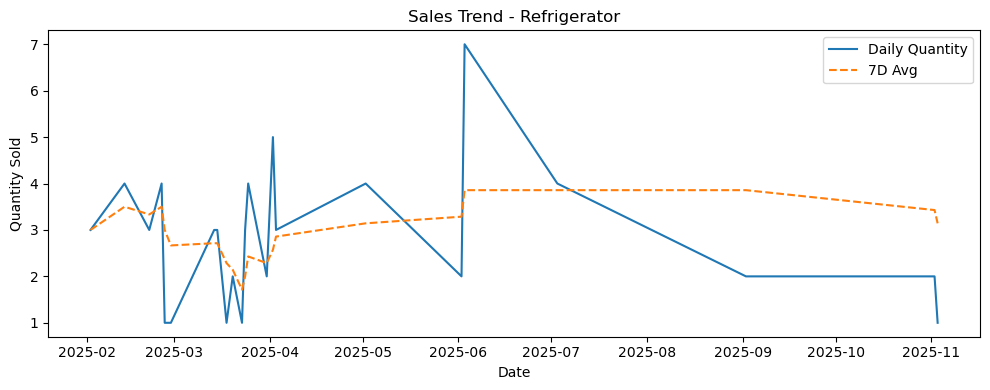

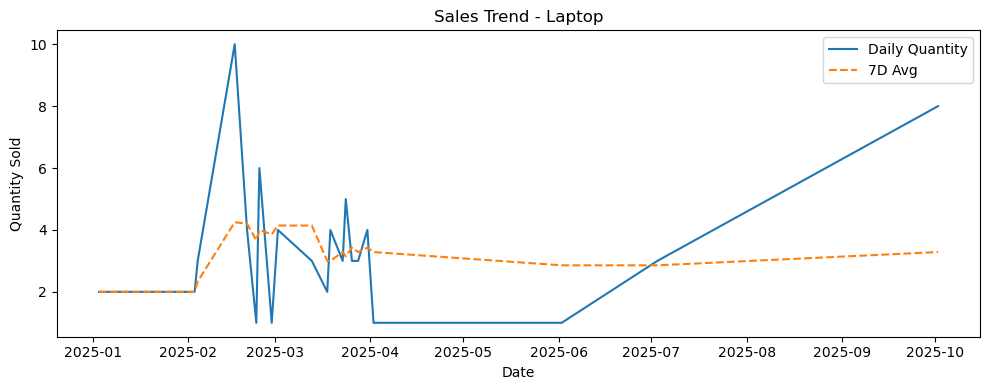

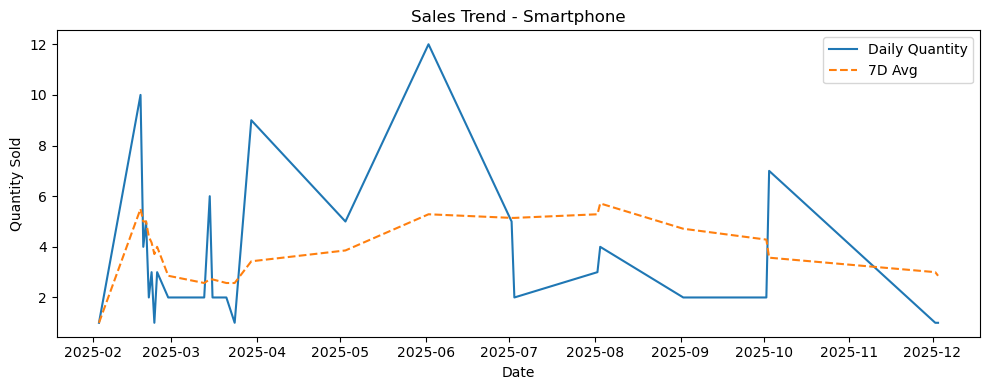

In [15]:
top3 = prod_summary.head(3)['Product'].tolist()

for product in top3:
    g = daily[daily['Product'] == product]
    plt.figure(figsize=(10, 4))
    plt.plot(g['Date'], g['Daily_Quantity'], label='Daily Quantity')
    plt.plot(g['Date'], g['Rolling_Avg_7D'], label='7D Avg', linestyle='--')
    plt.title(f"Sales Trend - {product}")
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
prod_summary.to_csv("Top_Products_by_Revenue.csv", index=False)
trend_df.to_csv("Trending_Products.csv", index=False)

print("\n✅ Analysis complete! Files saved:")
print("→ Top_Products_by_Revenue.csv")
print("→ Trending_Products.csv")


✅ Analysis complete! Files saved:
→ Top_Products_by_Revenue.csv
→ Trending_Products.csv
